
## Семинар 5. Практический пример


In [1]:
from sktime.datasets import load_uschange
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np


from sktime.forecasting.all import temporal_train_test_split
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

from sktime.forecasting.base import ForecastingHorizon

from sktime.datasets import load_macroeconomic, load_airline

from sktime.forecasting.model_selection import SlidingWindowSplitter, ExpandingWindowSplitter, ForecastingGridSearchCV
from sktime.transformations.series.boxcox import BoxCoxTransformer

from sktime.utils.plotting import plot_correlations


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,5)


### Общий алгоритм

Временные ряды отличаются некоторой спецификой. Основной проблемой при работе с такими данными является наличие утечек. На всех этапах работы с временными рядами обращайте внимание на потенциальные места, провоцирующие утечки. Ниже я собрал в одну схему некоторую последовательность действий, которые обычно следует совершить при работе с временными рядами. Разберём его по шагам.

![algorithm](images/sem_4_algorithm.png)


/var/folders/cp/4bl3kvm10tl3r81sxqkgg1q00000gn/T/ipykernel_20235/3109595427.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  y = pd.read_csv('./data/sem_4/hour_online.csv', index_col=['Time'], parse_dates=['Time']).Users


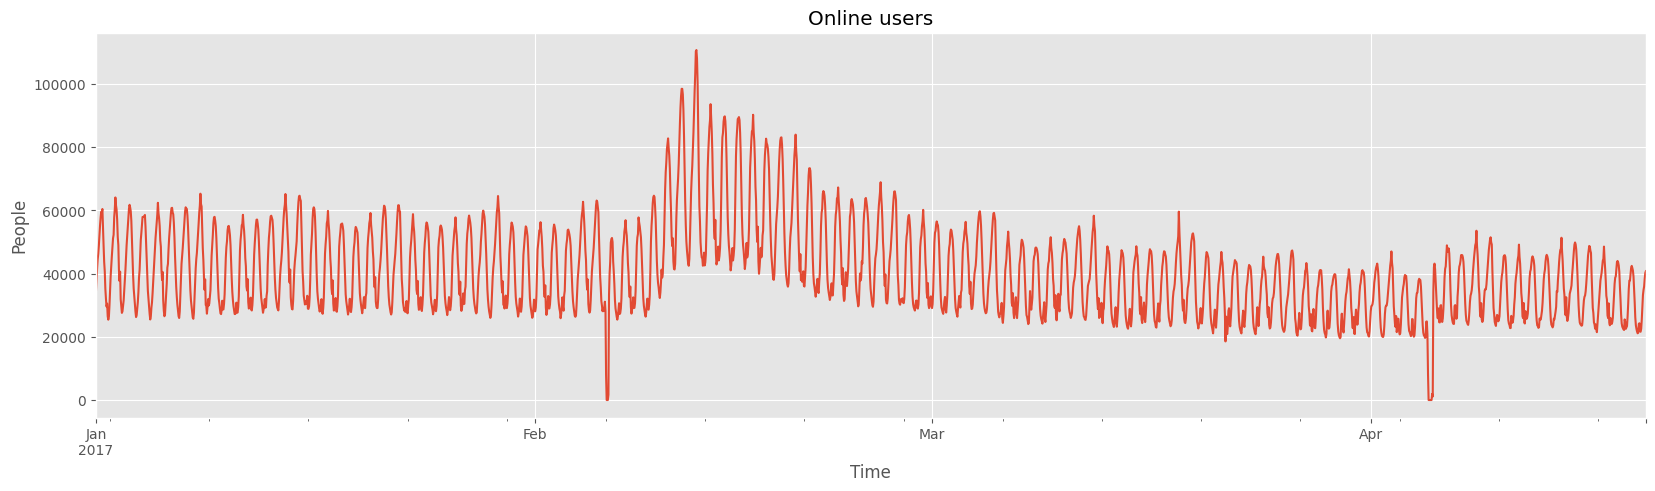

In [2]:
y = pd.read_csv('./data/sem_4/hour_online.csv', index_col=['Time'], parse_dates=['Time']).Users

# Вот этот шаг был неочевиден. С обычным datetime индексом всё ломалось по очевидной недоделке. Думаю, это скоро допилят
y.index = pd.PeriodIndex(y.index, freq="H")
y = y.astype(np.float64)

# y.diff().dropna().plot()
y.plot()
plt.title('Online users')
plt.ylabel('People');



In [3]:
test_size = 7*24

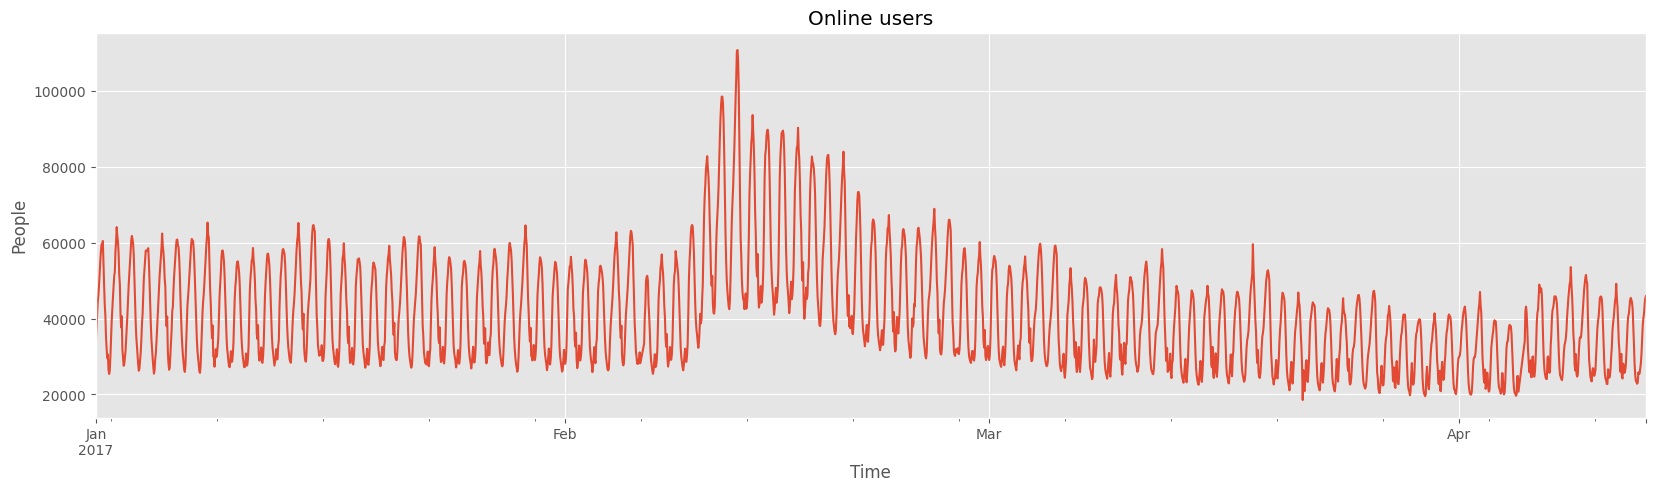

In [4]:
# Убираем выбросы и интерполируем
y[y<10000] = np.nan
y = y.interpolate()

y_train, y_test = temporal_train_test_split(y, test_size=test_size)
y_train.plot()


plt.title('Online users')
plt.ylabel('People');


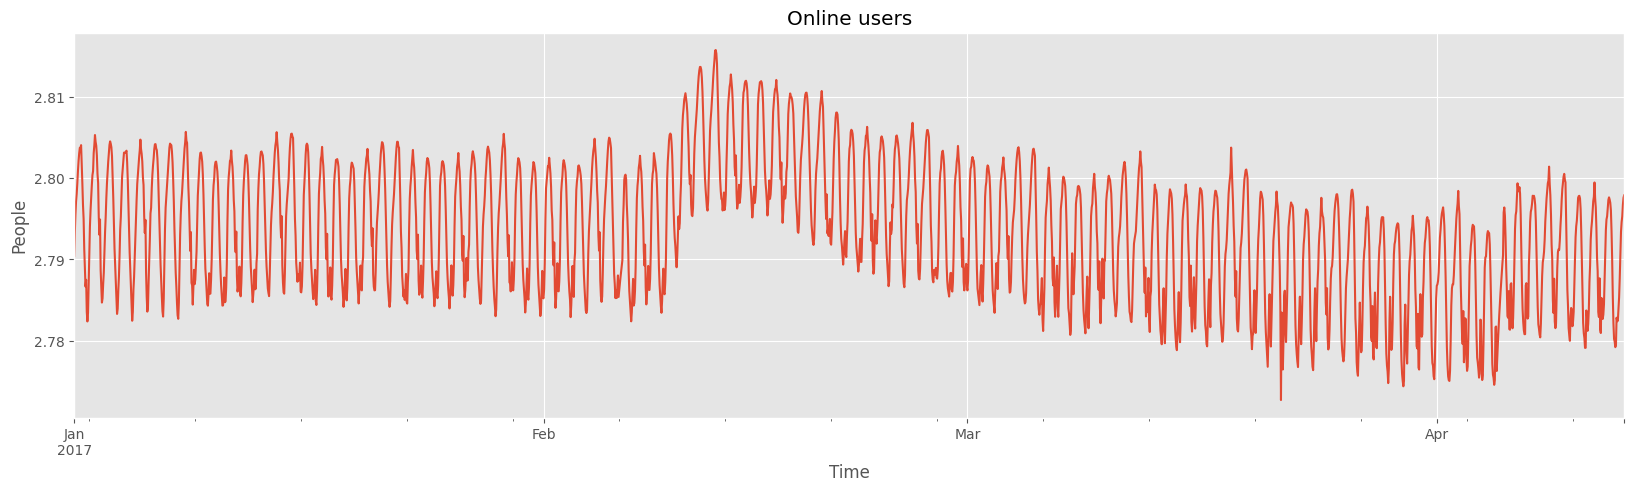

In [5]:

transformer = BoxCoxTransformer()
y_train_hat = transformer.fit_transform(y_train)


y_train_hat.plot()

plt.title('Online users')
plt.ylabel('People');


In [6]:
transformer.lambda_

-0.3489753582021295

In [7]:


fh = ForecastingHorizon(list(range(1, test_size+1)))

forecaster = AutoETS(sp=24)
param_grid = {
    'error': ['add', 'mul'],
    'trend': [None, 'add'],
    'seasonal': ['add','mul'],
}

In [8]:
len(y_train_hat)

2457

In [9]:
cv = SlidingWindowSplitter(
    window_length=1000,
    step_length=25,
    fh=fh)
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    verbose=1,
    n_jobs=-1
    )
gscv.fit(y_train_hat);

/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/sktime/forecasting/model_selection/_tune.py:198: UserWarning: in ForecastingGridSearchCV, n_jobs and pre_dispatch parameters are deprecated and will be removed in 0.26.0. Please use n_jobs and pre_dispatch directly in the backend_params argument instead.
  warn(
/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:455: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:455: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Users/mszekho

Fitting 52 folds for each of 8 candidates, totalling 416 fits
Fitting 51 folds for each of 4 candidates, totalling 204 fits


In [10]:
# Assuming gscv is your fitted ForecastingGridSearchCV object
cv_results = gscv.cv_results_

# Convert to DataFrame for easier viewing and analysis
results_df = pd.DataFrame(cv_results)

params_df = pd.json_normalize(results_df['params'])
# Concatenate the new parameters DataFrame with the original results minus the 'params' column
results_df_expanded = pd.concat([results_df.drop(columns=['params']), params_df], axis=1)

# Sort the DataFrame by rank of the test MAPE
results_df_sorted = results_df_expanded.sort_values(by='rank_test_MeanAbsolutePercentageError')

results_df_sorted.columns = [
    "Mean Test MAPE",
    "Mean Fit Time",
    "Mean Prediction Time",
    "Rank",
    "Error",
    "Seasonal",
    "Trend"
]

# Display the sorted DataFrame for comparison
results_df_sorted


,Mean Test MAPE,Mean Fit Time,Mean Prediction Time,Rank,Error,Seasonal,Trend
4,0.001047,0.271976,0.006023,1.0,mul,add,None
0,0.001047,0.234652,0.006482,2.0,add,add,None
6,0.001049,0.328766,0.006062,3.0,mul,mul,None
2,0.001049,0.280127,0.005557,4.0,add,mul,None
3,0.001110,0.343763,0.005867,5.0,add,mul,add
1,0.001110,0.302691,0.005823,6.0,add,add,add
5,0.001111,0.354739,0.005239,7.0,mul,add,add
7,0.001112,0.385465,0.005029,8.0,mul,mul,add


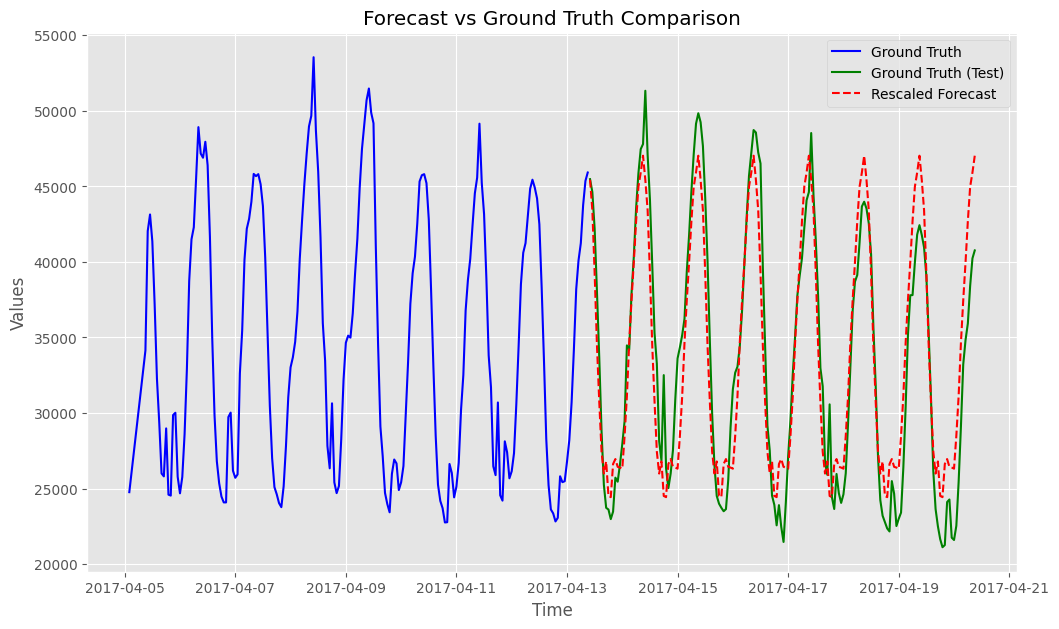

In [11]:
# Step 1: Identify the best forecaster
# (Assuming `gscv` is your fitted ForecastingGridSearchCV object)
best_forecaster = gscv.best_forecaster_

best_forecaster.fit(y_train_hat)

# Step 2: Generate forecast using the best forecaster
# Assuming `fh` is your forecasting horizon
forecast = best_forecaster.predict(fh)

# Step 3: Rescale forecast (if your transformer supports inverse_transform)
rescaled_forecast = transformer.inverse_transform(forecast)
# Selecting the last 100 observations from y_train
y_train_last = y_train.iloc[-200:]

# Assuming y_test is your actual test data
# (No need to adjust y_test, assuming it matches the forecast horizon)

plt.figure(figsize=(12, 7))

# Plotting the last 100 observations of y_train
plt.plot(y_train_last.index.to_timestamp(), y_train_last, label='Ground Truth', color='blue')

# Plotting the actual test data
plt.plot(y_test.index.to_timestamp(), y_test, label='Ground Truth (Test)', color='green')

# Plotting the rescaled forecast
plt.plot(forecast.index.to_timestamp(), rescaled_forecast, label='Rescaled Forecast', linestyle='--', color='red')

plt.legend()
plt.title('Forecast vs Ground Truth Comparison')
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()


In [12]:
forecast_standard = rescaled_forecast.copy()

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Users'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

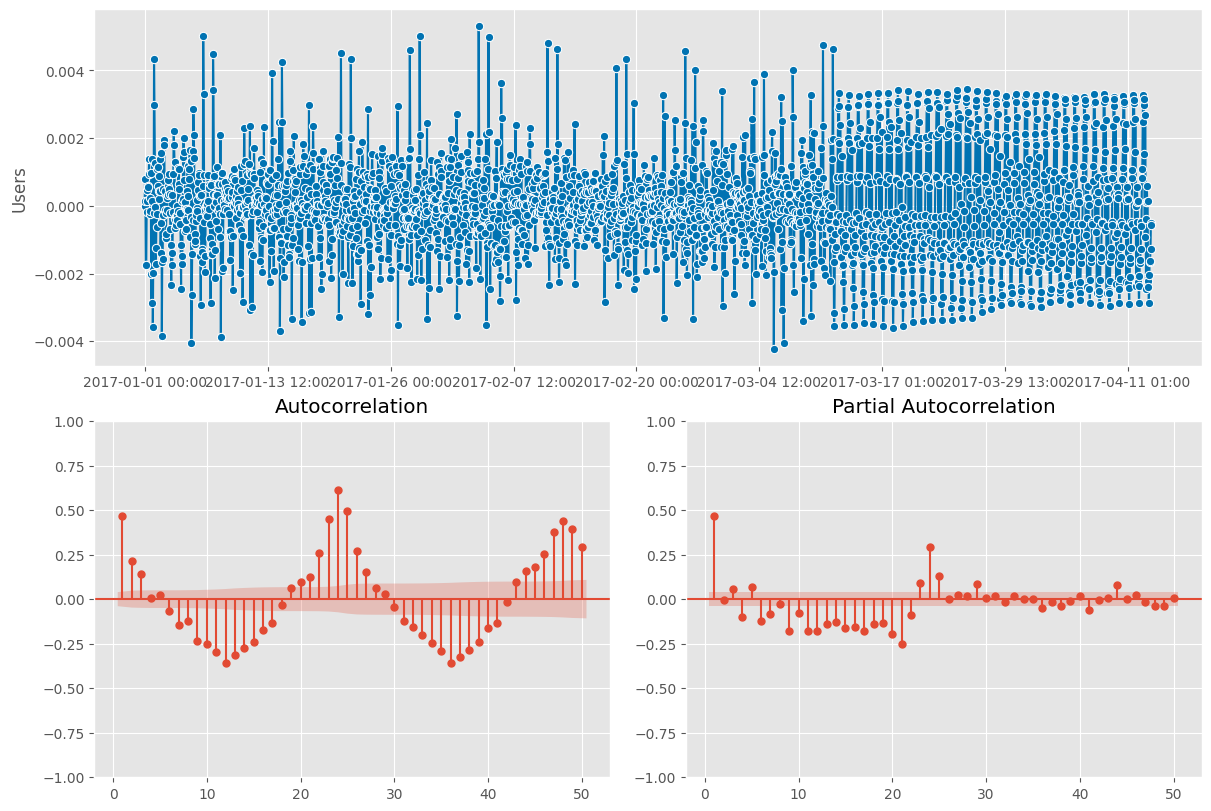

In [13]:

residuals = best_forecaster.predict_residuals()
plot_correlations(residuals, lags=50, zero_lag=False)

In [14]:
from statsmodels.tsa.stattools import acf
from scipy.stats import chi2


n_lags = 20
n_obs = len(residuals)
autocorrelations = acf(residuals, nlags=n_lags)[1:]
box_pirece_statistics = n_obs * (autocorrelations**2).sum()
box_pirece_statistics
box_pirece_pval = 1 - chi2.cdf(box_pirece_statistics, df=n_lags)

f"Box-Pierce test. Statistics: {box_pirece_statistics}, p-value: {box_pirece_pval}"

'Box-Pierce test. Statistics: 2334.5111362801117, p-value: 0.0'

In [15]:
denominators = n_obs - np.arange(1, n_lags+1)

In [16]:
n_lags = 20
n_obs = len(residuals)
autocorrelations = acf(residuals, nlags=n_lags)[1:]
ljung_box_statistics = n_obs * (n_obs +2) * ((autocorrelations**2 / denominators)).sum()
ljung_box_statistics
ljung_box_pval = 1 - chi2.cdf(ljung_box_statistics, df=n_lags)

f"Ljung-Box test. Statistics: {ljung_box_statistics}, p-value: {ljung_box_pval}"

'Ljung-Box test. Statistics: 2344.9705625793717, p-value: 0.0'

Box-pierce test

In [17]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(residuals, boxpierce=True, lags=n_lags)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,537.303748,7.277783e-119,536.648233,1.010663e-118
2,651.166194,3.990779e-142,650.325461,6.076036e-142
3,701.344059,1.072991e-151,700.401298,1.717999e-151
4,701.468878,1.675650e-150,700.525812,2.681544e-150
5,702.985709,1.110922e-149,702.038325,1.780448e-149
6,713.422058,7.734042e-151,712.440721,1.259821e-150
7,764.838316,7.162816e-161,763.668794,1.280516e-160
8,803.116871,4.382591e-168,801.791682,8.459523e-168
9,941.202405,8.172802e-197,939.259510,2.143538e-196
10,1094.149131,9.631435e-229,1091.459850,3.659264e-228


$\hat{y}_t = y_t - y_{t-24}$

In [18]:
class DiffTransformer:
    def __init__(self, n_lags):
        self.n_lags = n_lags 

    def fit_transform(self, x: pd.Series):
        return (x - x.shift(24)).dropna() + 1
    
    def inverse_transform(self, x: pd.Series, init_values:list):

        assert len(init_values) == self.n_lags

        x = x - 1
        for value in x.values:

            init_values.append(init_values[-self.n_lags] + value) 

        init_values = init_values[self.n_lags:]

        result = pd.Series(init_values, index = x.index) 

        return result
    

In [19]:
diff_transformer = DiffTransformer(n_lags=24)

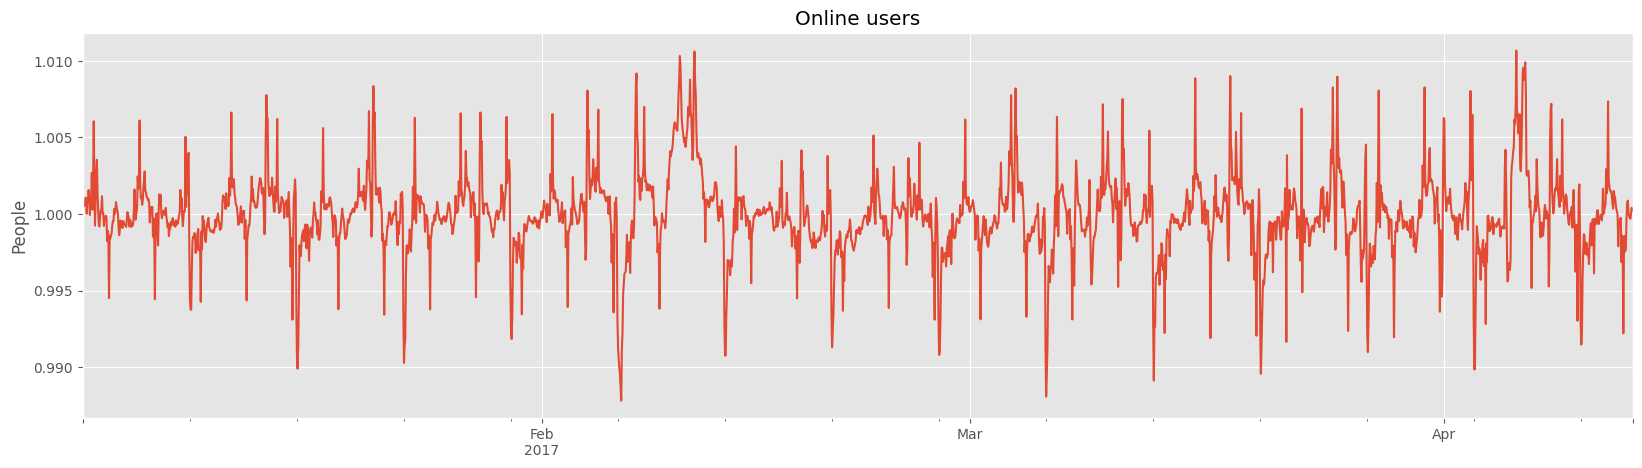

In [20]:
y_train_hat_diff = diff_transformer.fit_transform(y_train_hat)

y_train_hat_diff.plot()

plt.title('Online users')
plt.ylabel('People');

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Users'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

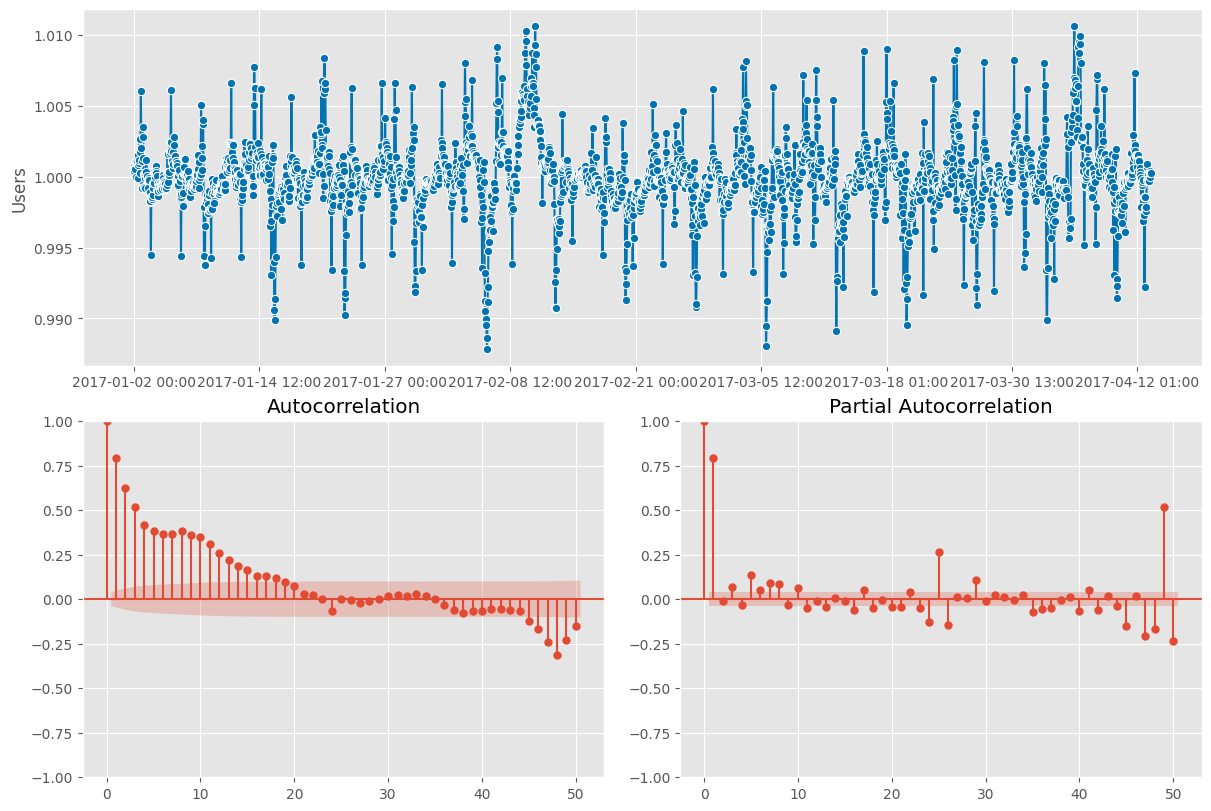

In [21]:
plot_correlations(y_train_hat_diff, lags=50)

In [22]:

forecaster = AutoETS(sp=24)
param_grid = {
    'error': ['add', 'mul'],
    'trend': [None, 'add'],
    'seasonal': ['add'],
}

cv = SlidingWindowSplitter(

    window_length=1000,
    step_length=25,
    fh=fh)
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    verbose=1,
    n_jobs=-1
    )


gscv.fit(y_train_hat_diff);

/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/sktime/forecasting/model_selection/_tune.py:198: UserWarning: in ForecastingGridSearchCV, n_jobs and pre_dispatch parameters are deprecated and will be removed in 0.26.0. Please use n_jobs and pre_dispatch directly in the backend_params argument instead.
  warn(
/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:455: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:455: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Users/mszekho

In [23]:
# Assuming gscv is your fitted ForecastingGridSearchCV object
cv_results = gscv.cv_results_

# Convert to DataFrame for easier viewing and analysis
results_df = pd.DataFrame(cv_results)

params_df = pd.json_normalize(results_df['params'])
# Concatenate the new parameters DataFrame with the original results minus the 'params' column
results_df_expanded = pd.concat([results_df.drop(columns=['params']), params_df], axis=1)

# Sort the DataFrame by rank of the test MAPE
results_df_sorted = results_df_expanded.sort_values(by='rank_test_MeanAbsolutePercentageError')

results_df_sorted.columns = [
    "Mean Test MAPE",
    "Mean Fit Time",
    "Mean Prediction Time",
    "Rank",
    "Error",
    "Seasonal",
    "Trend"
]

# Display the sorted DataFrame for comparison
results_df_sorted


,Mean Test MAPE,Mean Fit Time,Mean Prediction Time,Rank,Error,Seasonal,Trend
2,0.002512,0.223618,0.004162,1.0,mul,add,None
0,0.002512,0.193140,0.004404,2.0,add,add,None
1,0.002611,0.266861,0.004287,3.0,add,add,add
3,0.002617,0.338800,0.004066,4.0,mul,add,add


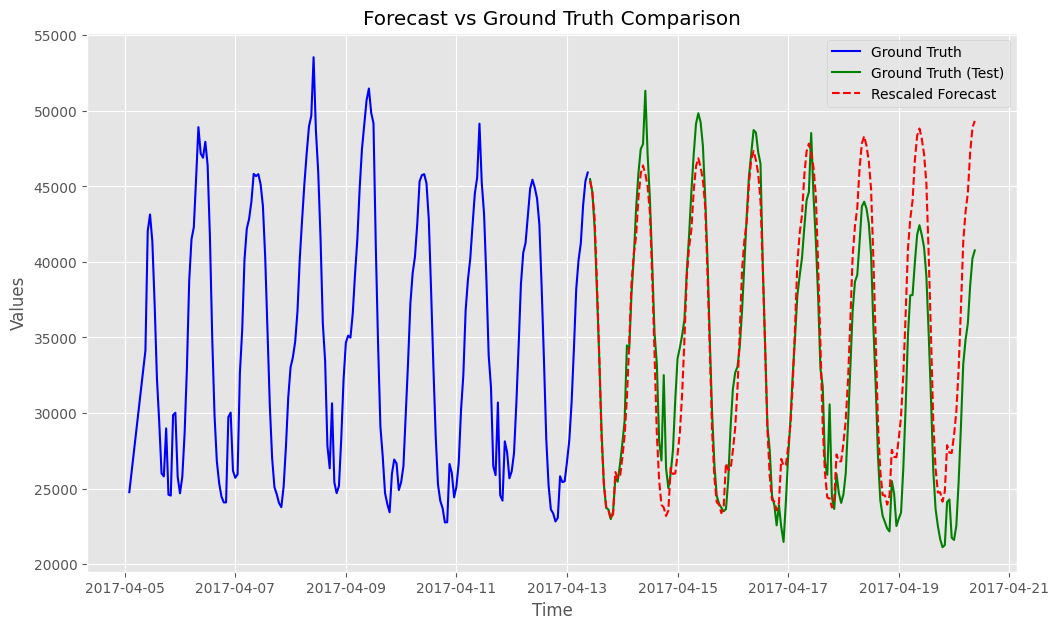

In [24]:
# Step 1: Identify the best forecaster
# (Assuming `gscv` is your fitted ForecastingGridSearchCV object)
best_forecaster = gscv.best_forecaster_

best_forecaster.fit(y_train_hat_diff)

# Step 2: Generate forecast using the best forecaster
# Assuming `fh` is your forecasting horizon
forecast = best_forecaster.predict(fh)

trended_forecast = diff_transformer.inverse_transform(forecast, y_train_hat.tail(24).to_list())
# Step 3: Rescale forecast (if your transformer supports inverse_transform)
rescaled_forecast = transformer.inverse_transform(trended_forecast)
# Selecting the last 100 observations from y_train
y_train_last = y_train.iloc[-200:]

# Assuming y_test is your actual test data
# (No need to adjust y_test, assuming it matches the forecast horizon)

plt.figure(figsize=(12, 7))

# Plotting the last 100 observations of y_train
plt.plot(y_train_last.index.to_timestamp(), y_train_last, label='Ground Truth', color='blue')

# Plotting the actual test data
plt.plot(y_test.index.to_timestamp(), y_test, label='Ground Truth (Test)', color='green')

# Plotting the rescaled forecast
plt.plot(forecast.index.to_timestamp(), rescaled_forecast, label='Rescaled Forecast', linestyle='--', color='red')

plt.legend()
plt.title('Forecast vs Ground Truth Comparison')
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()


In [25]:
forecast_diff = rescaled_forecast.copy()

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Users'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

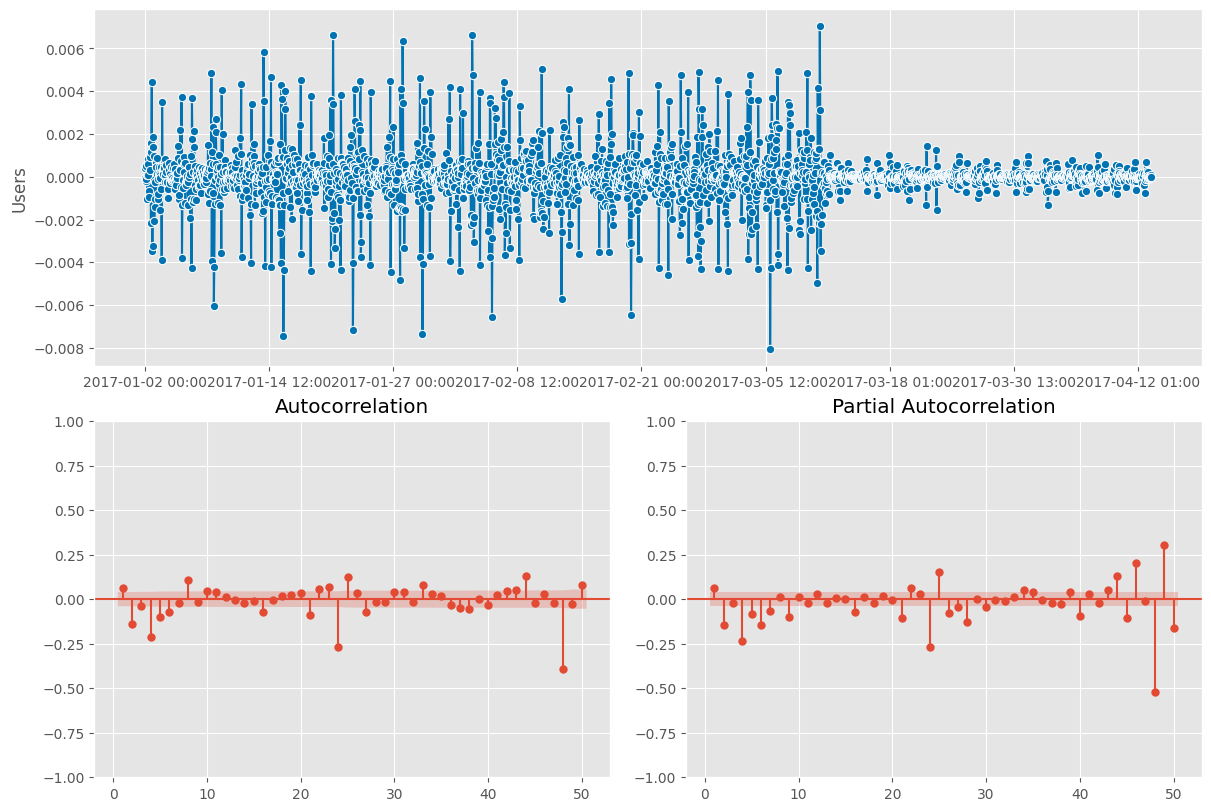

In [26]:

residuals = best_forecaster.predict_residuals()
plot_correlations(residuals, lags=50, zero_lag=False)

In [27]:
mean_absolute_percentage_error(y_true=y_test, y_pred=forecast_standard)


0.08453900766150084

In [28]:

mean_absolute_percentage_error(y_true=y_test, y_pred=forecast_diff)

0.08760909802239576

In [29]:
from dieboldmariano import dm_test

dm_test(y_test.to_list(), forecast_standard.to_list(), forecast_diff.to_list(), one_sided=True)

(-2.5740454451049053, 0.0054600080997925906)